# Mcculloch-Pitts Neuron

## Introduction
Mcculloch-Pitts Neuron is a simple model of a neuron. It takes a set of binary inputs and produces a binary output. The output is 1 if the weighted sum of the inputs is greater than a threshold value, and 0 otherwise. The model is named after Warren McCulloch and Walter Pitts, who introduced it in 1943. The model is also known as a threshold logic unit.  

In this network all inputs and outputs are binary. The inputs are either 0 or 1, and the output is either 0 or 1. 

We try to model a 4-bit, 2's complement circuit using Mcculloch-Pitts Neuron, the circuit is as follows:  

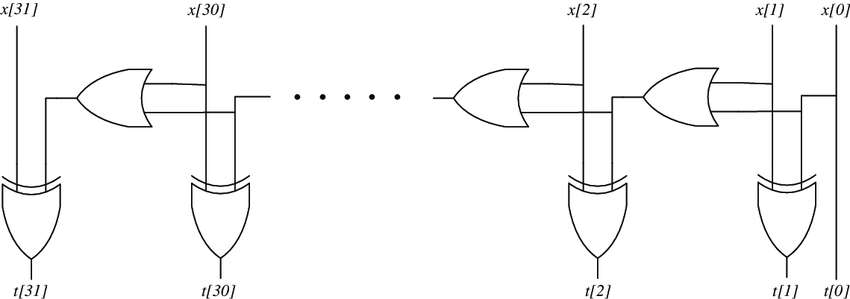

In [1]:
import numpy as np
import pandas as pd

from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from torch import nn, optim, tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

## Creating the dataset

We will create a dataset of 4-bit numbers and their 2's complement. The 2's complement of a number is obtained by inverting all the bits of the number and adding 1 to the least significant bit.

In [54]:
class TwosComplementDataset:
    def __init__(
        self, 
        n_samples: int = 1000, 
        n_bits: int = 4, 
        transform: Callable = None
    ):
        self._n_samples = n_samples
        self._n_bits = n_bits
        self._transform = transform
        self._generate_data()

    def _generate_data(self):
        self._x = np.random.randint(0, 2, (self._n_samples, self._n_bits))
        self._y = self._twos_complement(self._x)

        self._x = tensor(self._x, requires_grad=False)
        self._y = tensor(self._y, requires_grad=False)

    def _twos_complement(self, x: np.ndarray[np.ndarray[int]]) -> np.ndarray[int]:
        return np.array([self._twos_complement_single(x_i) for x_i in x])

    def _twos_complement_single(self, x: np.ndarray[int]) -> np.ndarray[int]:
        # if x[0] == 0: # real twos complement 
        #     return x
        if np.all(x == 0):
            return x
        last_one_idx = np.where(x == 1)[0][-1]
        x = np.copy(x)
        x[:last_one_idx] = 1 - x[:last_one_idx]
        return x

    def __len__(self):
        return self._n_samples

    def __getitem__(self, idx):
        x = self._x[idx]
        y = self._y[idx]

        if self._transform:
            x, y = self._transform(x, y)

        return x, y

    def get_data(self):
        return self._x, self._y

    def get_dataloader(self, batch_size: int = 32):
        return DataLoader(
            TensorDataset(self._x, self._y), batch_size=batch_size, shuffle=True
        )
        
    def show_samples(self, n_samples: int = 5):
        x, y = self.get_data()
        for i in range(n_samples):
            print(f"x: {x[i].numpy()}, y: {y[i].numpy()}")

In [55]:
dataset = TwosComplementDataset(n_samples=1000, n_bits=4)

In [56]:
dataset.show_samples()

x: [0 1 0 1], y: [1 0 1 1]
x: [1 1 0 0], y: [0 1 0 0]
x: [1 1 1 1], y: [0 0 0 1]
x: [0 0 0 1], y: [1 1 1 1]
x: [0 0 1 0], y: [1 1 1 0]
